# Colour - HDRI - Examples: Adobe DNG SDK Colour Processing

Through this example, some Canon EOS 5D Mark II *CR2* images will be white balanced using *Colour - HDRI* *Adobe DNG SDK* colour processing.

The following steps will be taken:

- Conversion of the *CR2* images to *DNG* files using [Adobe DNG Converter](http://www.adobe.com/support/downloads/detail.jsp?ftpID=5957).
- Conversion of the *DNG* files to intermediate demosaiced linear *Tiff* images using Dave Coffin's [dcraw](https://www.cybercom.net/~dcoffin/dcraw/).
- White balancing of the intermediate *Tiff* images using *Adobe DNG SDK* colour processing:
    - Reading of the *DNG* files *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the intermediate *Tiff* images using [OpenImageIO](http://openimageio.org/).
    - White balancing of the intermediate *Tiff* images.
    - Conversion of the intermediate *Tiff* images to *RGB* display colourspace.
- Display of the final resulting images.

## CR2 File Conversion to DNG and Intermediate File

In [1]:
import logging
import numpy as np
import os

import colour

from colour_hdri import (
    ROOT_RESOURCES_EXAMPLES,
    camera_neutral_to_xy,
    camera_space_to_XYZ_matrix,
    convert_dng_files_to_intermediate_files,
    convert_raw_files_to_dng_files,
    filter_files,
    read_dng_files_exif_tags,
    highlights_recovery_LCHab,
    update_exif_tags,
)
from colour_hdri.models import (
    CCS_ILLUMINANT_ADOBEDNG,
    CCT_ILLUMINANTS_ADOBEDNG,
    LIGHT_SOURCE_TAG_TO_DNG_ILLUMINANTS,
)

logging.basicConfig(level=logging.INFO)

ROOT_RESOURCES = os.path.join(ROOT_RESOURCES_EXAMPLES, "frobisher_001")

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.10.8 (main, Oct 12 2022, 09:32:59) [Clang 14.0.0           *
*   (clang-1400.0.29.102)]                                                    *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.4.1                                                        *
*       colour-hdri : v0.1.8-156-g0bc7147                                     *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.22.1                                                      *
*       matplotlib : 3.6.1                                                    *
*       numpy : 1.23.4                  

/Users/kelsolaar/Library/Caches/pypoetry/virtualenvs/colour-hdri-bkoxrqd3-py3.10/lib/python3.10/site-packages/colour/utilities/verbose.py:262: ColourUsageWarning: "colour_hdri.camera_space_to_XYZ_matrix" object has been renamed to "colour_hdri.matrix_camera_space_to_XYZ".
  warn(*args, **kwargs)


In [2]:
RAW_FILES = filter_files(ROOT_RESOURCES, ("CR2",))

DNG_FILES = convert_raw_files_to_dng_files(RAW_FILES, ROOT_RESOURCES)


def matrix_camera_space_to_XYZ(exif_tags):
    exif_group = exif_tags["EXIF"]
    CCT_calibration_illuminant_1 = CCT_ILLUMINANTS_ADOBEDNG[
        LIGHT_SOURCE_TAG_TO_DNG_ILLUMINANTS[exif_group["Calibration Illuminant 1"]]
    ]
    CCT_calibration_illuminant_2 = CCT_ILLUMINANTS_ADOBEDNG[
        LIGHT_SOURCE_TAG_TO_DNG_ILLUMINANTS[exif_group["Calibration Illuminant 2"]]
    ]
    M_color_matrix_1 = exif_group["Color Matrix 1"]
    M_color_matrix_2 = exif_group["Color Matrix 2"]
    M_camera_calibration_1 = exif_group["Camera Calibration 1"]
    M_camera_calibration_2 = exif_group["Camera Calibration 2"]
    analog_balance = exif_group["Analog Balance"]
    M_forward_matrix_1 = exif_group["Forward Matrix 1"]
    M_forward_matrix_2 = exif_group["Forward Matrix 2"]
    as_shot_neutral = exif_group["As Shot Neutral"]

    logging.info(f'"As Shot Neutral": "{as_shot_neutral}"...')
    xy = camera_neutral_to_xy(
        as_shot_neutral,
        CCT_calibration_illuminant_1,
        CCT_calibration_illuminant_2,
        M_color_matrix_1,
        M_color_matrix_2,
        M_camera_calibration_1,
        M_camera_calibration_2,
        analog_balance,
    )

    M_camera_space_to_XYZ = camera_space_to_XYZ_matrix(
        xy,
        CCT_calibration_illuminant_1,
        CCT_calibration_illuminant_2,
        M_color_matrix_1,
        M_color_matrix_2,
        M_camera_calibration_1,
        M_camera_calibration_2,
        analog_balance,
        M_forward_matrix_1,
        M_forward_matrix_2,
    )

    logging.info(f'"Camera Space to XYZ": "{M_camera_space_to_XYZ}"...')

    return M_camera_space_to_XYZ


M_CAMERA_SPACE_TO_XYZ = matrix_camera_space_to_XYZ(
    read_dng_files_exif_tags((DNG_FILES[0],))[0]
)

# In order to avoid artefacts, white balancing should be peformed before
# demosaicing thus we need to pass appropriate gains to *dcraw*.
WHITE_BALANCE_MULTIPLIERS = colour.algebra.vector_dot(M_CAMERA_SPACE_TO_XYZ, np.ones(3))

RAW_CONVERTER_ARGUMENTS = (
    '-t 0 -H 1 -r {0} {1} {2} {1} -4 -q 3 -o 0 -T "{{raw_file}}"'.format(
        *WHITE_BALANCE_MULTIPLIERS
    )
)

INTERMEDIATE_FILES = convert_dng_files_to_intermediate_files(
    DNG_FILES,
    ROOT_RESOURCES,
    raw_converter_arguments=RAW_CONVERTER_ARGUMENTS,
)

update_exif_tags(zip(DNG_FILES, INTERMEDIATE_FILES))

INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.dng" file.
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.CR2" file to "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.dng" file.
*** GPU Warning: GPU3 disabled via cr_config at init time. ***
INFO:root:Converting "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.CR2" file to "/Users/kelsolaar/Documents/Development/

True

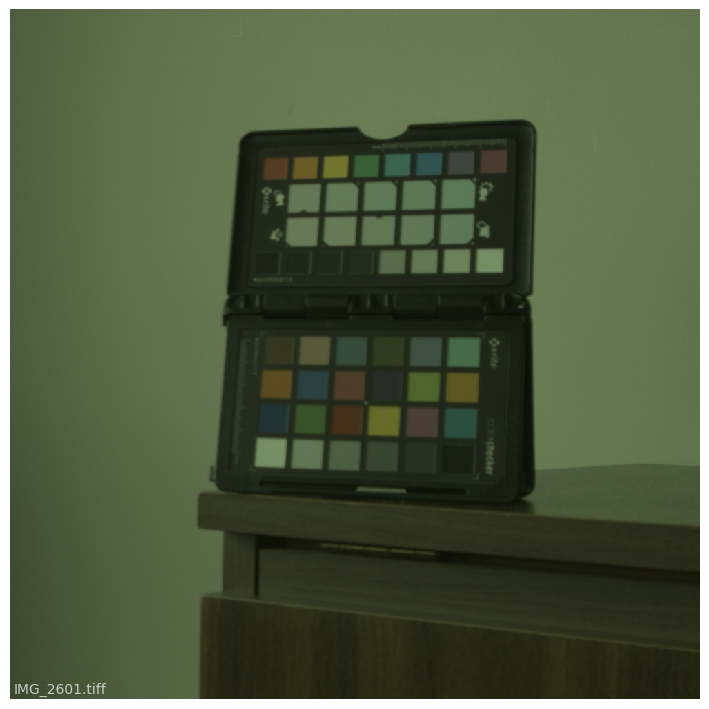

In [3]:
colour.plotting.plot_image(
    colour.cctf_encoding(
        colour.read_image(str(INTERMEDIATE_FILES[-2]))[1400:2400, 3200:4200, ...]
    ),
    text_kwargs={"text": os.path.basename(INTERMEDIATE_FILES[-2])},
);

## Adobe DNG SDK Colour Processing

In [4]:
def process_raw_files(dng_files, output_directory):
    paths = []
    for dng_file in dng_files:
        path = str(dng_file.replace("dng", "tiff"))
        image = colour.read_image(path)

        image *= 1 / WHITE_BALANCE_MULTIPLIERS
        image *= np.max(WHITE_BALANCE_MULTIPLIERS)

        image = colour.algebra.vector_dot(M_CAMERA_SPACE_TO_XYZ, image)
        image = colour.XYZ_to_sRGB(
            image, CCS_ILLUMINANT_ADOBEDNG, apply_cctf_encoding=False
        )

        path = os.path.join(
            output_directory,
            "{0}.{1}".format(os.path.splitext(os.path.basename(path))[0], "exr"),
        )
        paths.append(path)

        logging.info("Recovering highlights...")
        # NOTE: In some edge cases, the threshold for highlights
        # recovery can be negative because of out of gamut values.
        # For such cases you can perform the recovery in a larger
        # RGB colourspace such as *ACES 2065-1* or *Xtreme RGB*.
        RGB_t = colour.XYZ_to_sRGB(
            WHITE_BALANCE_MULTIPLIERS,
            CCS_ILLUMINANT_ADOBEDNG,
            apply_cctf_encoding=False,
        )
        image = highlights_recovery_LCHab(image, RGB_t[1])

        logging.info(f'Writing "{path}"...')
        colour.write_image(image, path)

    return paths


PATHS = process_raw_files(DNG_FILES, ROOT_RESOURCES)

INFO:root:Recovering highlights...
INFO:root:Writing "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.exr"...
INFO:root:Recovering highlights...
INFO:root:Writing "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.exr"...
INFO:root:Recovering highlights...
INFO:root:Writing "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.exr"...
INFO:root:Recovering highlights...
INFO:root:Writing "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2601.exr"...
INFO:root:Recovering highlights...
INFO:root:Writing "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IM

## Image Display

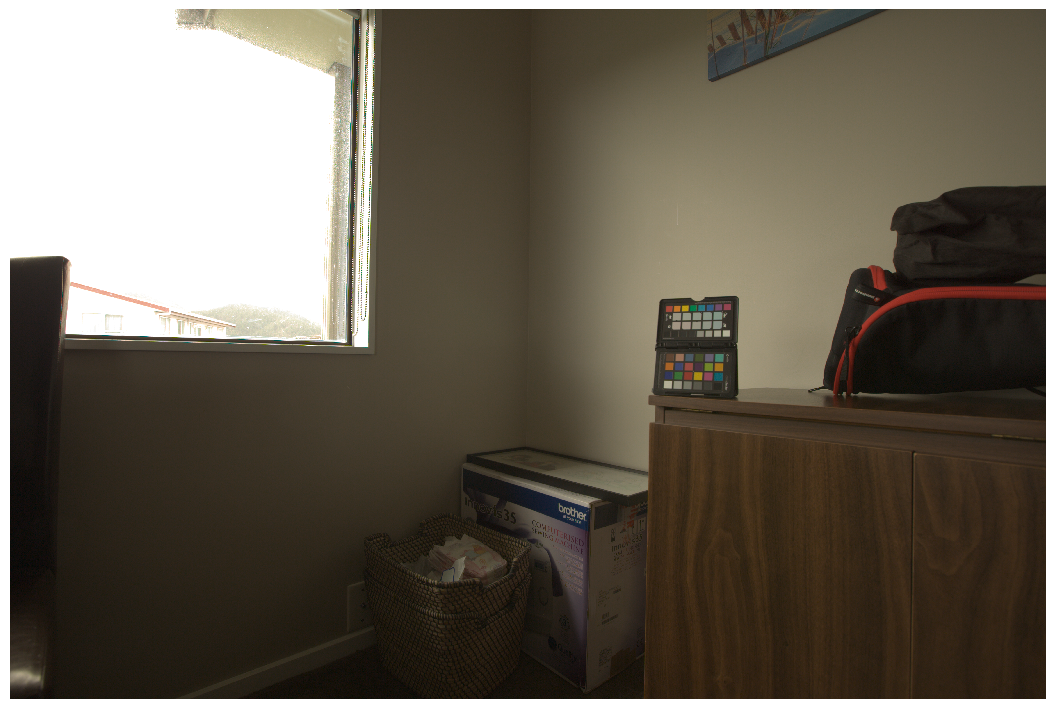

In [5]:
colour.plotting.plot_image(colour.cctf_encoding(colour.read_image(PATHS[-2])));